In [1]:
import os
import glob

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import datetime
import time

import warnings
warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)

import plotly.express as px
import plotly.graph_objects as go

from sklearn.preprocessing import RobustScaler

In [2]:
master_data = pd.read_csv("../data/processed/master_data.csv", engine="pyarrow")
# filter dates until 2018-08 only
master_data = master_data[~master_data["order_purchase_timestamp"].dt.strftime('%Y-%m').isin(["2018-09", "2018-10"])]
master_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 107835 entries, 0 to 107834
Data columns (total 23 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   customer_unique_id             107835 non-null  object        
 1   customer_id                    107835 non-null  object        
 2   customer_zip_code_prefix       107835 non-null  int64         
 3   customer_city                  107835 non-null  object        
 4   customer_state                 107835 non-null  object        
 5   order_id                       107835 non-null  object        
 6   order_status                   107835 non-null  object        
 7   order_purchase_timestamp       107835 non-null  datetime64[ns]
 8   order_approved_at              107693 non-null  datetime64[ns]
 9   order_delivered_carrier_date   105949 non-null  datetime64[ns]
 10  order_delivered_customer_date  104691 non-null  datetime64[ns]
 11  order

## ML with RFM Features

In [3]:
master_data[master_data.duplicated(subset=["order_id"], keep=False)][["customer_unique_id", "order_id", "order_status", "order_purchase_timestamp", "payment_sequential", "payment_value", "order_item_count"]].head()

,customer_unique_id,order_id,order_status,order_purchase_timestamp,payment_sequential,payment_value,order_item_count
0,b7d76e111c89f7ebf14761390f0f7d17,2e7a8482f6fb09756ca50c10d7bfc047,shipped,2016-09-04 21:15:19,1.0,136.23,1.0
1,b7d76e111c89f7ebf14761390f0f7d17,2e7a8482f6fb09756ca50c10d7bfc047,shipped,2016-09-04 21:15:19,1.0,136.23,1.0
29,df2988ba3ed226b10521a0e4da849b61,63638a6806d67773f3adba8534553fff,delivered,2016-10-04 13:22:56,1.0,15.10,1.0
30,df2988ba3ed226b10521a0e4da849b61,63638a6806d67773f3adba8534553fff,delivered,2016-10-04 13:22:56,2.0,11.99,1.0
31,df2988ba3ed226b10521a0e4da849b61,63638a6806d67773f3adba8534553fff,delivered,2016-10-04 13:22:56,3.0,9.02,1.0


In [4]:
# aggregate sum of order_item_count with same payment_sequential
customer_activity = master_data.groupby(["customer_unique_id", "order_id", "order_status", "order_purchase_timestamp", "payment_sequential", "payment_value"], as_index=False).agg(
    order_item_count = ("order_item_count", "sum")
).sort_values(by=["order_purchase_timestamp", "order_id"], ignore_index=True)
customer_activity[customer_activity.duplicated(subset=["order_id"], keep=False)].head()

,customer_unique_id,order_id,order_status,order_purchase_timestamp,payment_sequential,payment_value,order_item_count
28,df2988ba3ed226b10521a0e4da849b61,63638a6806d67773f3adba8534553fff,delivered,2016-10-04 13:22:56,1.0,15.10,1.0
29,df2988ba3ed226b10521a0e4da849b61,63638a6806d67773f3adba8534553fff,delivered,2016-10-04 13:22:56,2.0,11.99,1.0
30,df2988ba3ed226b10521a0e4da849b61,63638a6806d67773f3adba8534553fff,delivered,2016-10-04 13:22:56,3.0,9.02,1.0
31,df2988ba3ed226b10521a0e4da849b61,63638a6806d67773f3adba8534553fff,delivered,2016-10-04 13:22:56,4.0,10.56,1.0
32,df2988ba3ed226b10521a0e4da849b61,63638a6806d67773f3adba8534553fff,delivered,2016-10-04 13:22:56,5.0,34.19,1.0


In [5]:
# aggregate sum of payment_value with different payment_sequential
customer_activity = customer_activity.groupby(["customer_unique_id", "order_id", "order_status", "order_purchase_timestamp", "order_item_count"], as_index=False).agg(
    payment_value = ("payment_value", "sum")
).sort_values(by=["order_purchase_timestamp", "order_id"], ignore_index=True)
customer_activity[customer_activity.duplicated(subset=["order_id"], keep=False)]

,customer_unique_id,order_id,order_status,order_purchase_timestamp,order_item_count,payment_value


In [6]:
# get current date, assumption is one day after last order_purchase_timestamp
max_date = customer_activity["order_purchase_timestamp"].max() + datetime.timedelta(1)

# create recency, frequency, monetary per customer_unique_id
rfm_data = customer_activity.groupby("customer_unique_id", as_index=False).agg(
    recency =  ("order_purchase_timestamp", lambda x: (max_date-x.max()).days),
    frequency = ("order_id", lambda x: x.nunique()),
    monetary =  ("payment_value", "sum")
)

rfm_data.describe().T

,count,mean,std,min,25%,50%,75%,max
recency,96090.0,241.672089,153.400070,1.0,117.00,222.0,351.0000,726.00
frequency,96090.0,1.034665,0.213879,1.0,1.00,1.0,1.0000,17.00
monetary,96090.0,166.552049,231.324551,0.0,63.12,108.0,183.5175,13664.08


### Outliers

In [7]:
def detect_bounds(data, method="iqr"):
    if method == "iqr":
        q1, q3 = np.percentile(data, 25), np.percentile(data, 75)
        iqr = q3 - q1
        lower, upper = q1 - (1.5 * iqr), q3 + (1.5 * iqr)
    if method == "mad":
        med = data.median()
        mad = abs(data - med).median()
        lower, upper = med - mad, med + mad
    return round(lower,2), round(upper,2)

In [8]:
tmp = pd.DataFrame(columns=["variable", "method", "lower_threshold", "upper_threshold", "n_outlier", "pct_outlier"])
for col in ["recency", "monetary"]:
    for method in ["iqr"]:#, "mad"]:
        lower, upper = detect_bounds(rfm_data[col], method=method)
        n_outlier = len(rfm_data[(rfm_data[col] > upper) | (rfm_data[col] < lower)])
        pct_outlier = round(n_outlier/len(rfm_data)*100,2)
        tmp.loc[len(tmp)] = [col, method, lower, upper, n_outlier, pct_outlier]
tmp

,variable,method,lower_threshold,upper_threshold,n_outlier,pct_outlier
0,recency,iqr,-234.00,702.00,4,0.00
1,monetary,iqr,-117.48,364.11,7650,7.96


In [9]:
_, monetary_upper_thres = detect_bounds(rfm_data["monetary"], method="iqr")
print(monetary_upper_thres)

rfm_data_clean = rfm_data[rfm_data["monetary"] <= monetary_upper_thres].copy()
rfm_data_clean.describe().T

364.11


,count,mean,std,min,25%,50%,75%,max
recency,88440.0,241.704692,153.190237,1.0,118.00,223.00,351.00,726.0
frequency,88440.0,1.026888,0.171595,1.0,1.00,1.00,1.00,6.0
monetary,88440.0,118.823089,75.708569,0.0,60.08,99.74,160.21,364.1


### Feature Engineering

#### Robust Scaler

In [10]:
scaler = RobustScaler()
# rfm_scaled = scaler.fit_transform(rfm_data[["recency", "frequency", "monetary"]])
rfm_scaled = scaler.fit_transform(rfm_data_clean[["recency", "frequency", "monetary"]])

tmp = pd.DataFrame(rfm_scaled)
tmp.columns = ["recency_", "frequency", "monetary"]
tmp.describe().T

,count,mean,std,min,25%,50%,75%,max
recency_,88440.0,0.080278,0.657469,-0.952790,-0.450644,0.0,0.549356,2.158798
frequency,88440.0,0.026888,0.171595,0.000000,0.000000,0.0,0.000000,5.000000
monetary,88440.0,0.190583,0.756103,-0.996105,-0.396085,0.0,0.603915,2.640168


### Benchmark Model

In [11]:
# models
from sklearn.cluster import KMeans # centroid-based
from sklearn.cluster import DBSCAN # density-based
from sklearn.cluster import Birch # tree, hierarchical

# evaluation metrics
from sklearn.metrics import silhouette_score, davies_bouldin_score

#### All Models

In [ ]:
kmeans = KMeans(n_clusters=4, random_state=0)

#dbscan = DBSCAN(eps=0.3, min_samples=15, n_jobs=-1)
dbscan = DBSCAN(eps=0.5, min_samples=5, n_jobs=-1)

# greater radius threshold, greater cluster radius & smaller number of clusters formed
# greater branching factor, greater number of subclusters under a node
birch = Birch(n_clusters=4, threshold=0.5, branching_factor=50)

In [ ]:
metrics = []
model = {
    "KMeans": kmeans,
    "DBSCAN": dbscan,
    "Birch" : birch
}

for name, estimator in model.items():
    print(f"training model {name}")
    
    start = time.time()
    result = estimator.fit_predict(rfm_scaled)
    fit_time = time.time() - start
    
    start = time.time()
    silhouette = silhouette_score(rfm_scaled, result)
    silhouette_time = time.time() - start
    
    start = time.time()
    davies = davies_bouldin_score(rfm_scaled, result)
    davies_time = time.time() - start
    
    metrics.append({
        "model" : name,
        "silhouette_score": silhouette,
        "davies_bouldin_score": davies,
        "n_cluster": len(np.unique(result)),
        "fit_time": fit_time,
        "silhouette_score_time": silhouette_time,
        "davies_score_time": davies_time
    })
        
PROPS = "color:#000000;font-weight:bold;background-color:#FFFF00"
metrics_data = pd.DataFrame(metrics).style.\
    highlight_min(subset=["davies_bouldin_score", "fit_time"], props=PROPS).\
    highlight_max(subset=["silhouette_score"], props=PROPS)
metrics_data

training model KMeans
training model DBSCAN
training model Birch


,model,silhouette_score,davies_bouldin_score,n_cluster,fit_time,silhouette_score_time,davies_score_time
0,KMeans,0.369448,0.935939,4,0.427079,89.900982,0.015717
1,DBSCAN,0.307481,1.943562,4,119.003435,89.572183,0.016384
2,Birch,0.397173,0.824946,4,1.254238,85.284859,0.016907


### Tuning K-Means

#### Tune

In [ ]:
n_clusters = list(range(2,10))
kmeans_tuning = []

for n_clust in n_clusters:
    print(f"cluster = {n_clust}", end="\r")
    model = KMeans(n_clusters=n_clust,
                    max_iter=300,
                    init="k-means++",
                    n_init=1,
                    tol=1e-4,
                    algorithm="lloyd",
                    random_state=0)
    result = model.fit_predict(rfm_scaled)
    
    silhouette = silhouette_score(rfm_scaled, result, metric="euclidean")
    davies = davies_bouldin_score(rfm_scaled, result)
    
    kmeans_tuning.append({
        "clusters": n_clust,
        "silhouette_score": silhouette,
        "davies_bouldin_score": davies,
        "inertia": model.inertia_
    })

In [ ]:
kmeans_tuning_data = pd.DataFrame(kmeans_tuning)
#kmeans_tuning_data.to_csv("../data/kmeans_tuning_without_outliers.csv", index=False)

#### Visualize Metrics

In [12]:
kmeans_tuning_data = pd.read_csv("../data/kmeans_tuning_without_outliers.csv")

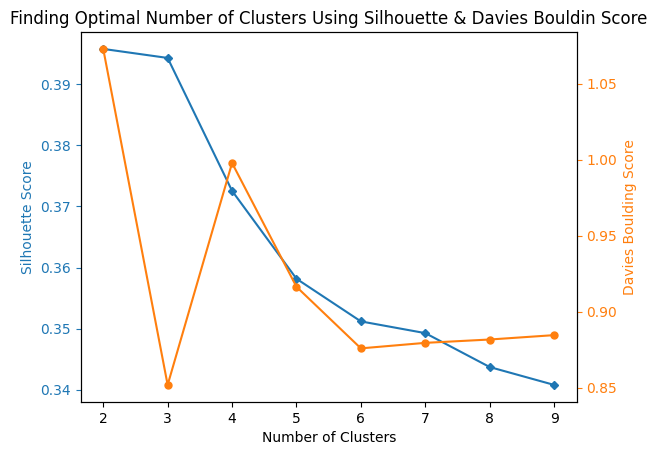

In [13]:
fig, ax = plt.subplots()
ax.plot(kmeans_tuning_data["clusters"], kmeans_tuning_data["silhouette_score"], color="C0", marker="D", ms=4)
ax2 = ax.twinx()
ax2.plot(kmeans_tuning_data["clusters"], kmeans_tuning_data["davies_bouldin_score"], color="C1", marker="o", ms=5)

ax.tick_params(axis="y", colors="C0")
ax2.tick_params(axis="y", colors="C1")

ax.set_ylabel('Silhouette Score', color='C0')
ax2.set_ylabel('Davies Boulding Score', color='C1')

ax.set_xlabel('Number of Clusters')
plt.title('Finding Optimal Number of Clusters Using Silhouette & Davies Bouldin Score')
plt.show()

#### Visualize Clusters

In [14]:
model = KMeans(
    n_clusters=6,
    max_iter=300,
    init="k-means++",
    n_init=1,
    tol=1e-4,
    algorithm="lloyd",
    random_state=0)
model.fit_predict(rfm_scaled)

kmeans_segmentation = rfm_data_clean.copy()
kmeans_segmentation["clusters"] = model.labels_

In [30]:
def plot_rfm_segmentation(data, hue=None, size=None, size_order=None, hue_order=None):
    if not hue:
        hue = 'clusters'

    if not size:
        size = 'clusters'

    if not size_order:
        size_order = data["clusters"]
    
    if not hue_order:
        hue_order = data["clusters"]

    plt.figure(figsize=(24,8), facecolor='w')
    plt.subplot(131)
    sns.scatterplot(x='recency', 
                    y='frequency', 
                    hue=hue, 
                    data=data, 
                    size=size, 
                    sizes=(50,150), 
                    size_order=size_order, 
                    hue_order=hue_order, 
                    palette='Spectral')
    plt.title('Customer Segment by Recency & Frequency',fontsize=16)
    plt.xlabel('Recency',fontsize=14)
    plt.ylabel('Frequency',fontsize=14)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)

    plt.subplot(132)
    sns.scatterplot(x='recency', 
                    y='monetary', 
                    hue=hue, 
                    data=data, 
                    size=size, 
                    sizes=(50,150), 
                    size_order=size_order,
                    hue_order=hue_order, 
                    palette='Spectral')
    plt.title('Customer Segment by Recency & Monetary',fontsize=16)
    plt.xlabel('Recency',fontsize=14)
    plt.ylabel('Monetary',fontsize=14)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)

    plt.subplot(133)
    sns.scatterplot(x='frequency', 
                    y='monetary', 
                    hue=hue, 
                    data=data, 
                    size=size, 
                    sizes=(50,150), 
                    size_order=size_order,
                    hue_order=hue_order,
                    palette='Spectral')
    plt.title('Customer Segment by Frequency & Monetary',fontsize=16)
    plt.xlabel('Frequency',fontsize=14)
    plt.ylabel('Monetary',fontsize=14)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)

    plt.tight_layout()
    plt.show()

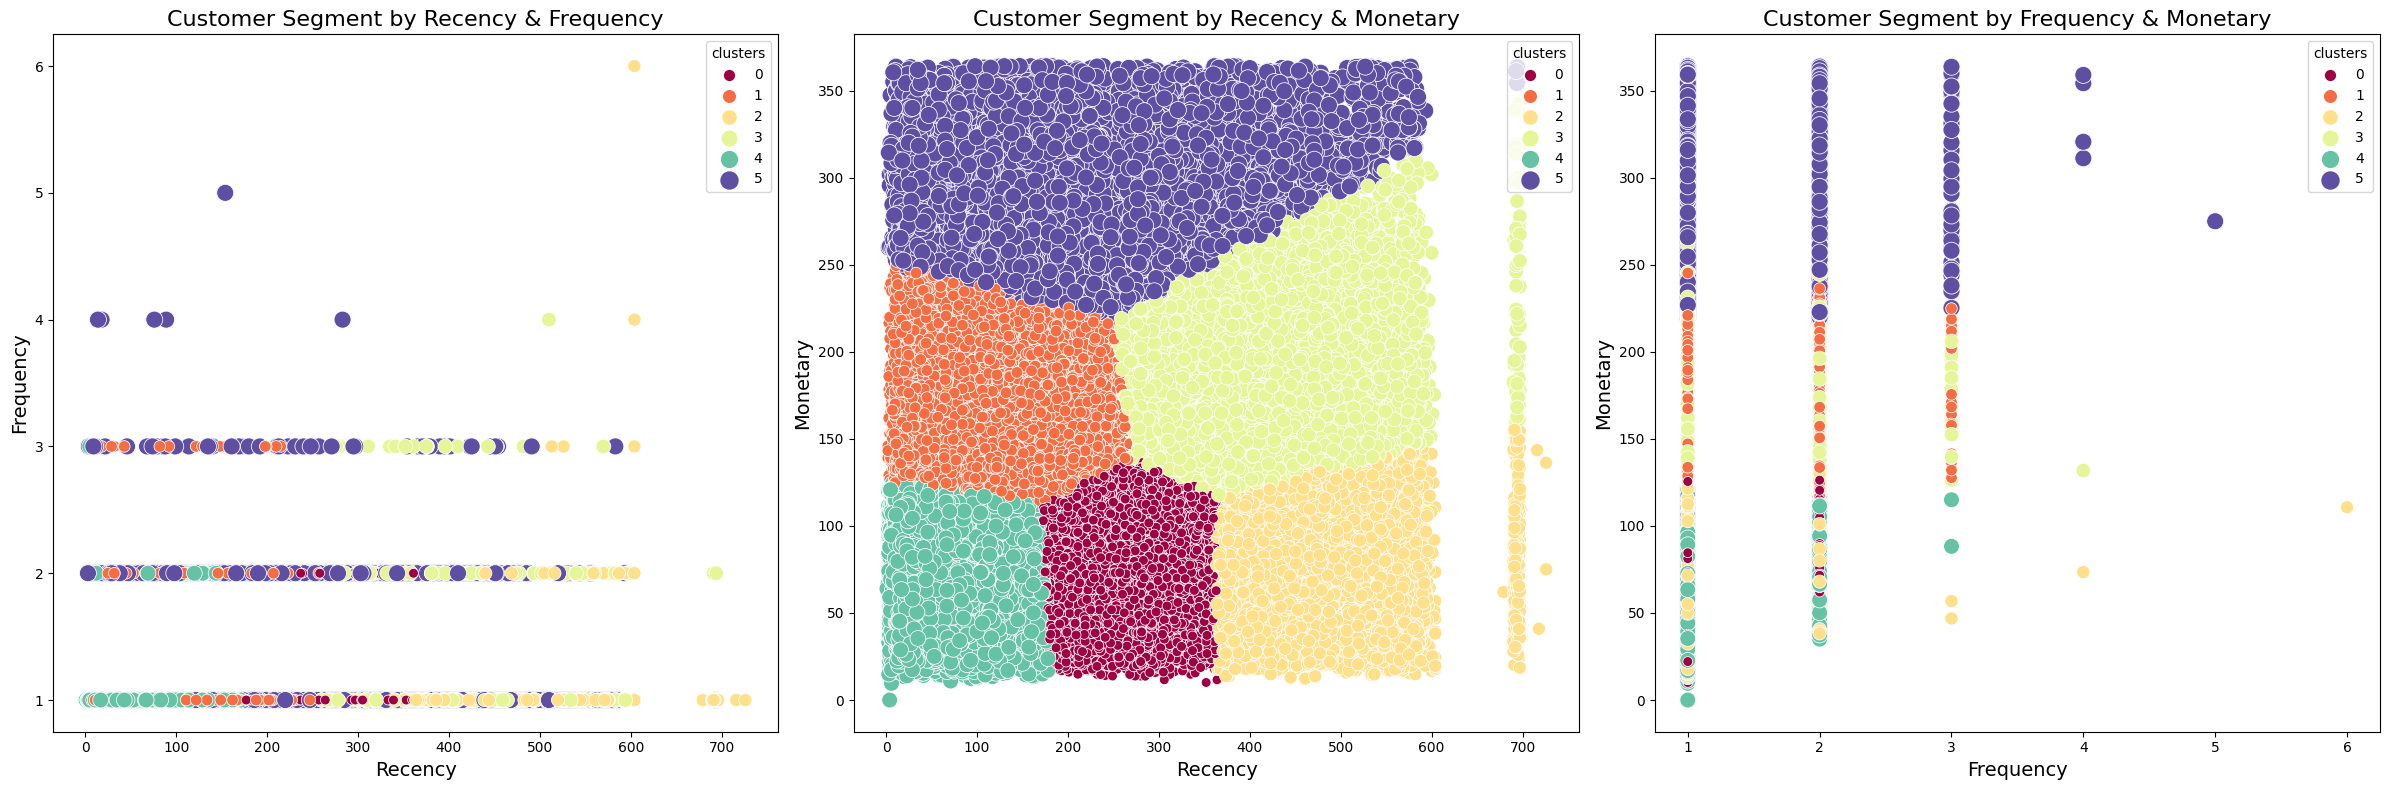

In [28]:
plot_rfm_segmentation(kmeans_segmentation)

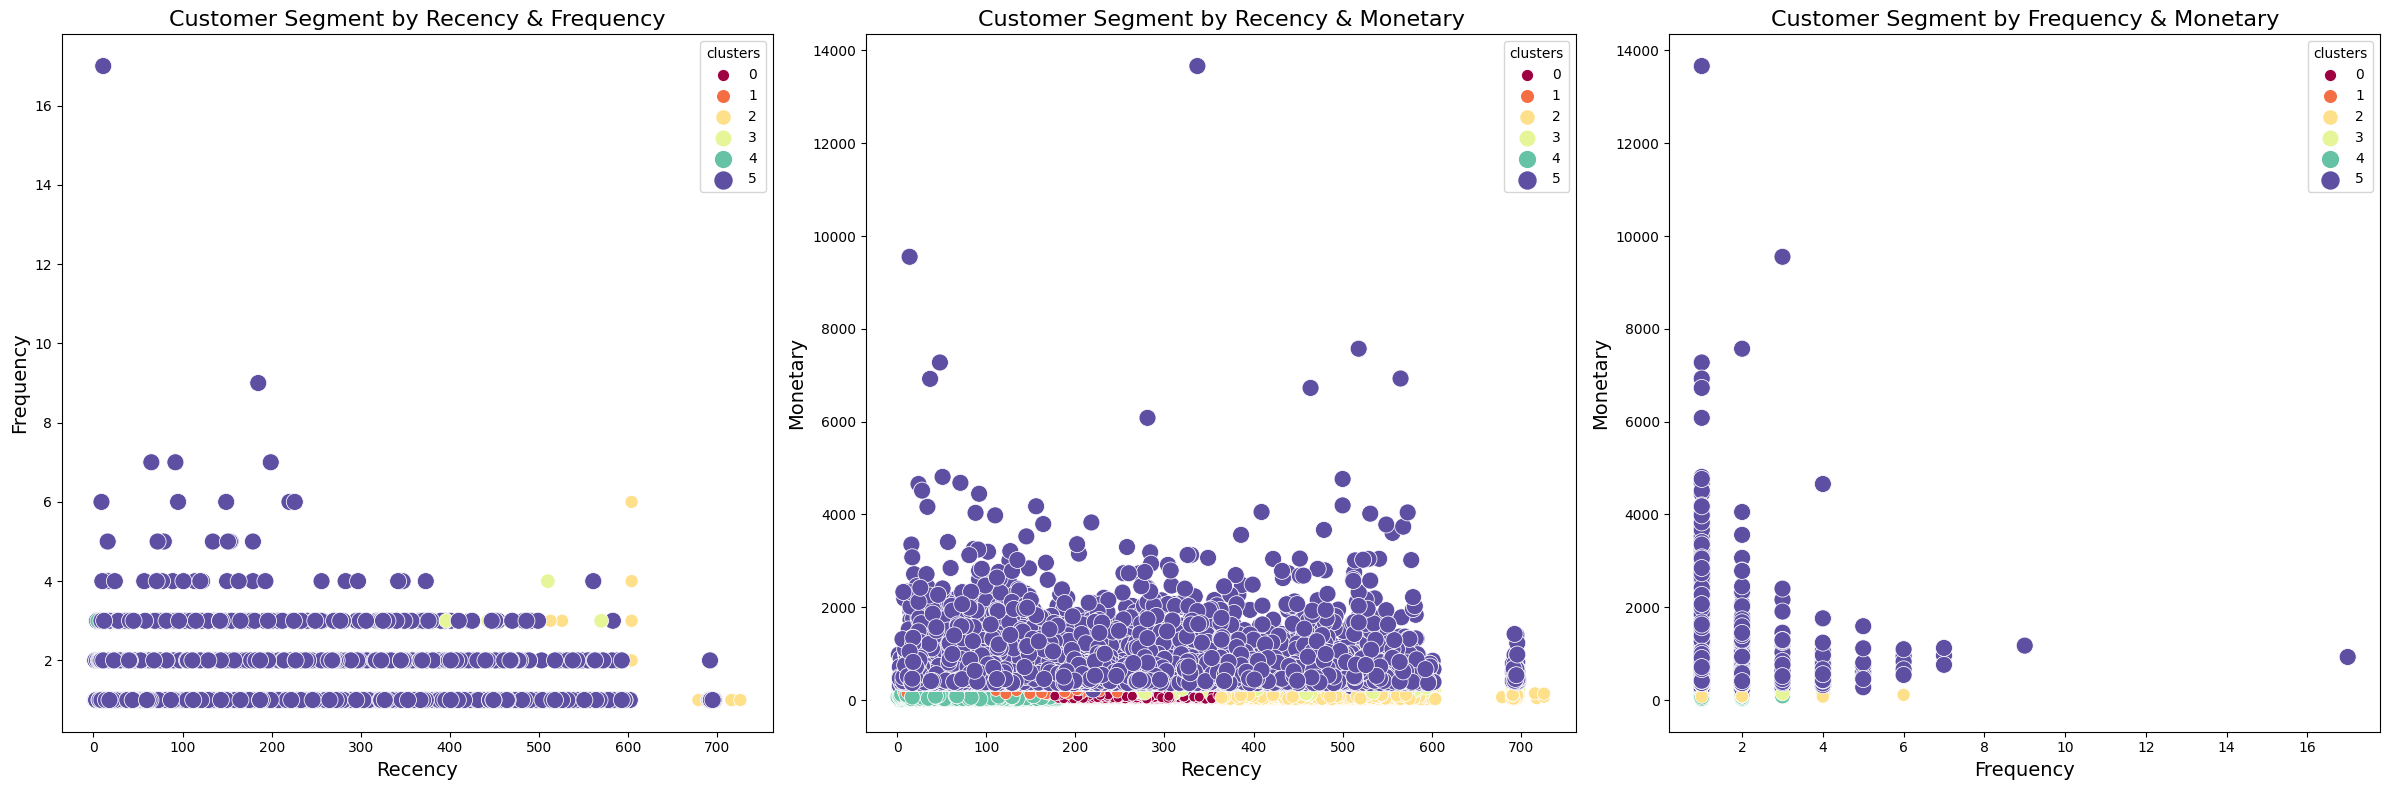

In [18]:
rfm_monetary_outliers = rfm_data[rfm_data["monetary"] > monetary_upper_thres].copy()
rfm_monetary_outliers["clusters"] = [max(np.unique(model.labels_))] * len(rfm_monetary_outliers)

plot_rfm_segmentation(pd.concat([kmeans_segmentation, rfm_monetary_outliers], axis=0))

### Tuning BIRCH

#### Tune

In [ ]:
n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
threshold = [0.4, 0.5, 0.6, 0.7]

birch_tuning = []

for n_clust in n_clusters:
    for thres in threshold:
            print(f"cluster, threshold = {n_clust}, {thres}", end="\r")
            model = Birch(n_clusters=n_clust, threshold=thres)
            result = model.fit_predict(rfm_scaled)
            
            silhouette = silhouette_score(rfm_scaled, result, metric="euclidean")
            davies = davies_bouldin_score(rfm_scaled, result)
            
            birch_tuning.append({
                "clusters": n_clust
                #"clusters_set": n_clust,
                #"clusters_formed": len(np.unique(result)),
                "threshold": thres,
                "silhouette_score": silhouette,
                "davies_bouldin_score": davies
            })


birch_tuning_data = pd.DataFrame(birch_tuning)
#birch_tuning_data.to_csv("../data/birch_tuning_without_outliers.csv", index=False)

In [ ]:
# threshold = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
# for thres in threshold:
#     model = Birch(n_clusters=None, threshold=thres, branching_factor=50)
#     result = model.fit_predict(rfm_scaled)
#     davies = davies_bouldin_score(rfm_scaled, result)
#     print(len(np.unique(result)), thres, davies)

#### Visualize Metrics

In [19]:
birch_tuning_data = pd.read_csv("../data/birch_tuning_without_outliers.csv")
birch_tuning_data[birch_tuning_data["clusters"] > 3].sort_values(by=["silhouette_score", "davies_bouldin_score"], ascending=[False, True], ignore_index=True).head()

,clusters,threshold,silhouette_score,davies_bouldin_score
0,4,0.5,0.397173,0.824946
1,4,0.7,0.364277,0.862697
2,8,0.7,0.360112,0.789650
3,9,0.7,0.359390,0.796322
4,4,0.4,0.357593,1.111741


In [20]:
birch_viz = birch_tuning_data[birch_tuning_data["threshold"]==0.7]

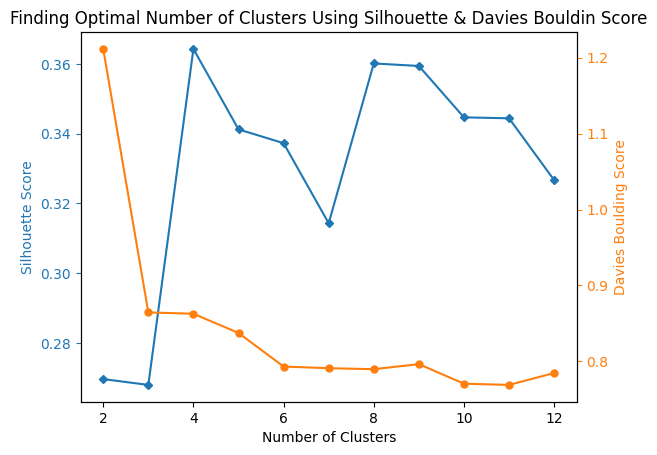

In [21]:
fig, ax = plt.subplots()
ax.plot(birch_viz["clusters"], birch_viz["silhouette_score"], color="C0", marker="D", ms=4)
ax2 = ax.twinx()
ax2.plot(birch_viz["clusters"], birch_viz["davies_bouldin_score"], color="C1", marker="o", ms=5)

ax.tick_params(axis="y", colors="C0")
ax2.tick_params(axis="y", colors="C1")

ax.set_ylabel('Silhouette Score', color='C0')
ax2.set_ylabel('Davies Boulding Score', color='C1')

ax.set_xlabel('Number of Clusters')
plt.title('Finding Optimal Number of Clusters Using Silhouette & Davies Bouldin Score')
plt.show()

#### Visualize Clusters

In [22]:
model = Birch(n_clusters=8, threshold=0.7, branching_factor=50)
model.fit_predict(rfm_scaled)

birch_segmentation = rfm_data_clean.copy()
birch_segmentation["clusters"] = model.labels_

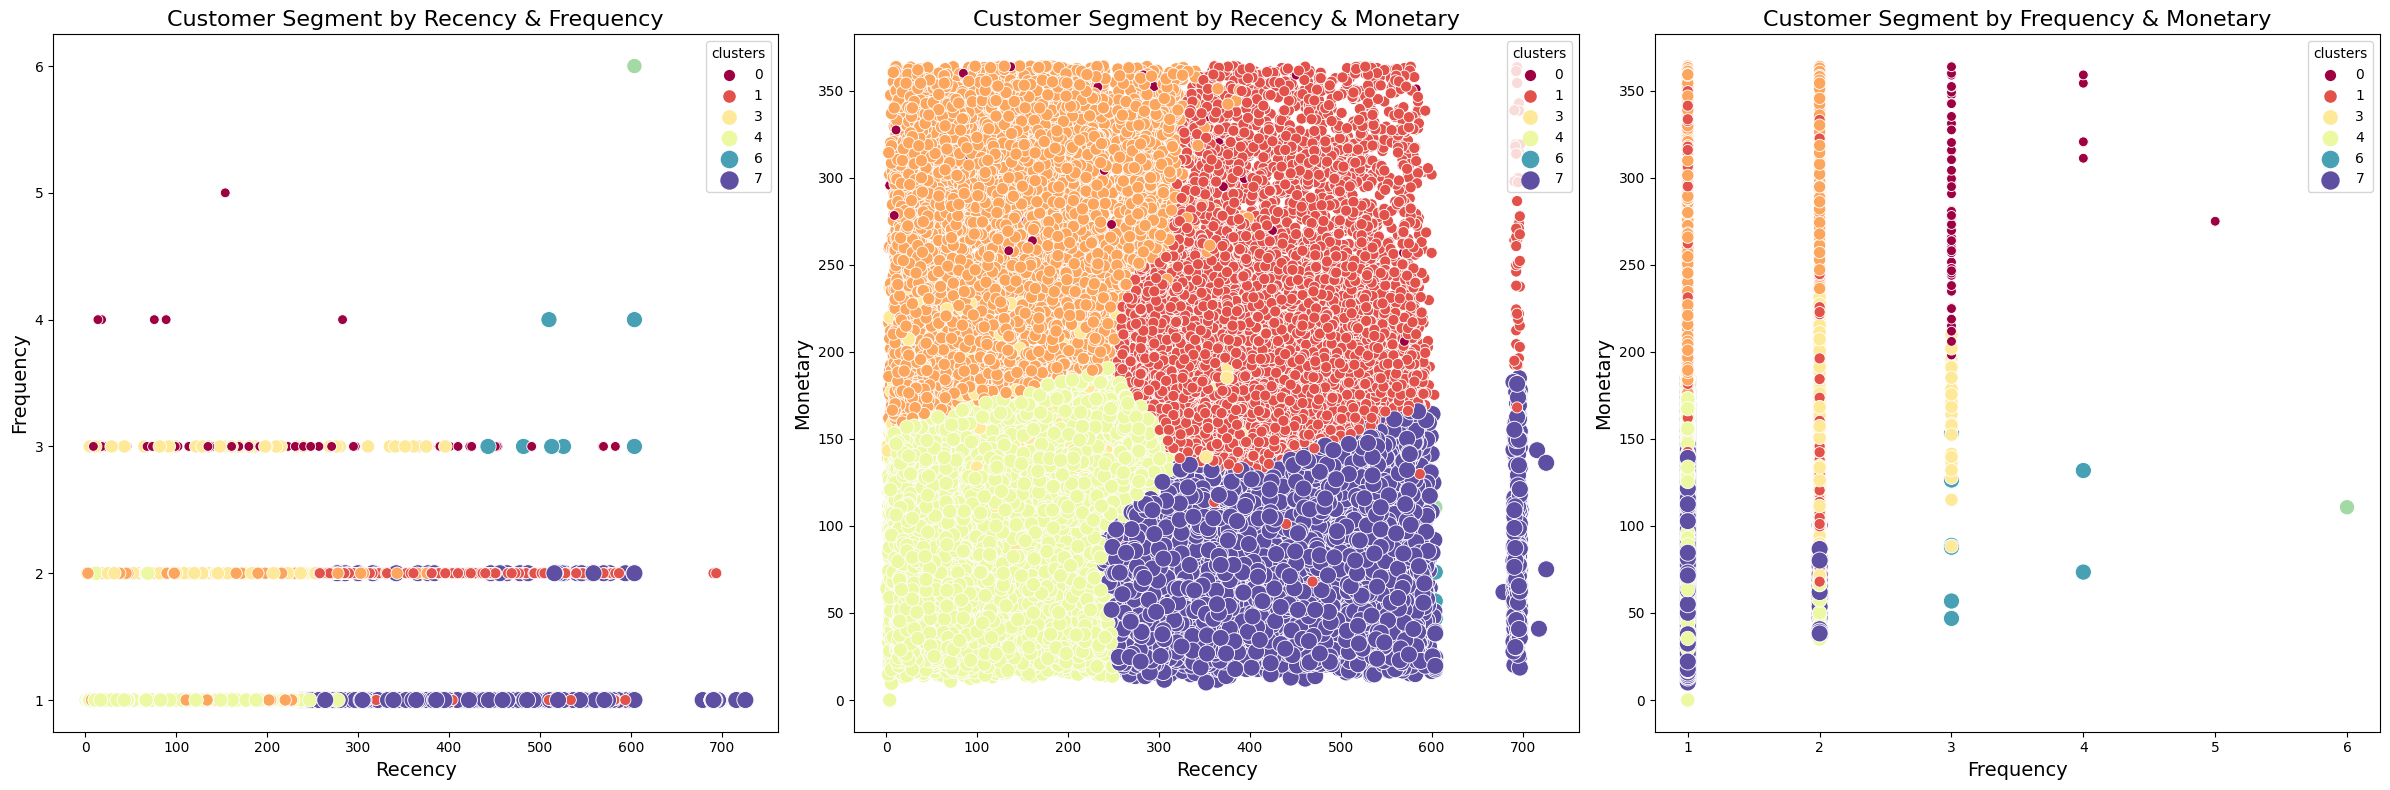

In [23]:
plot_rfm_segmentation(birch_segmentation)

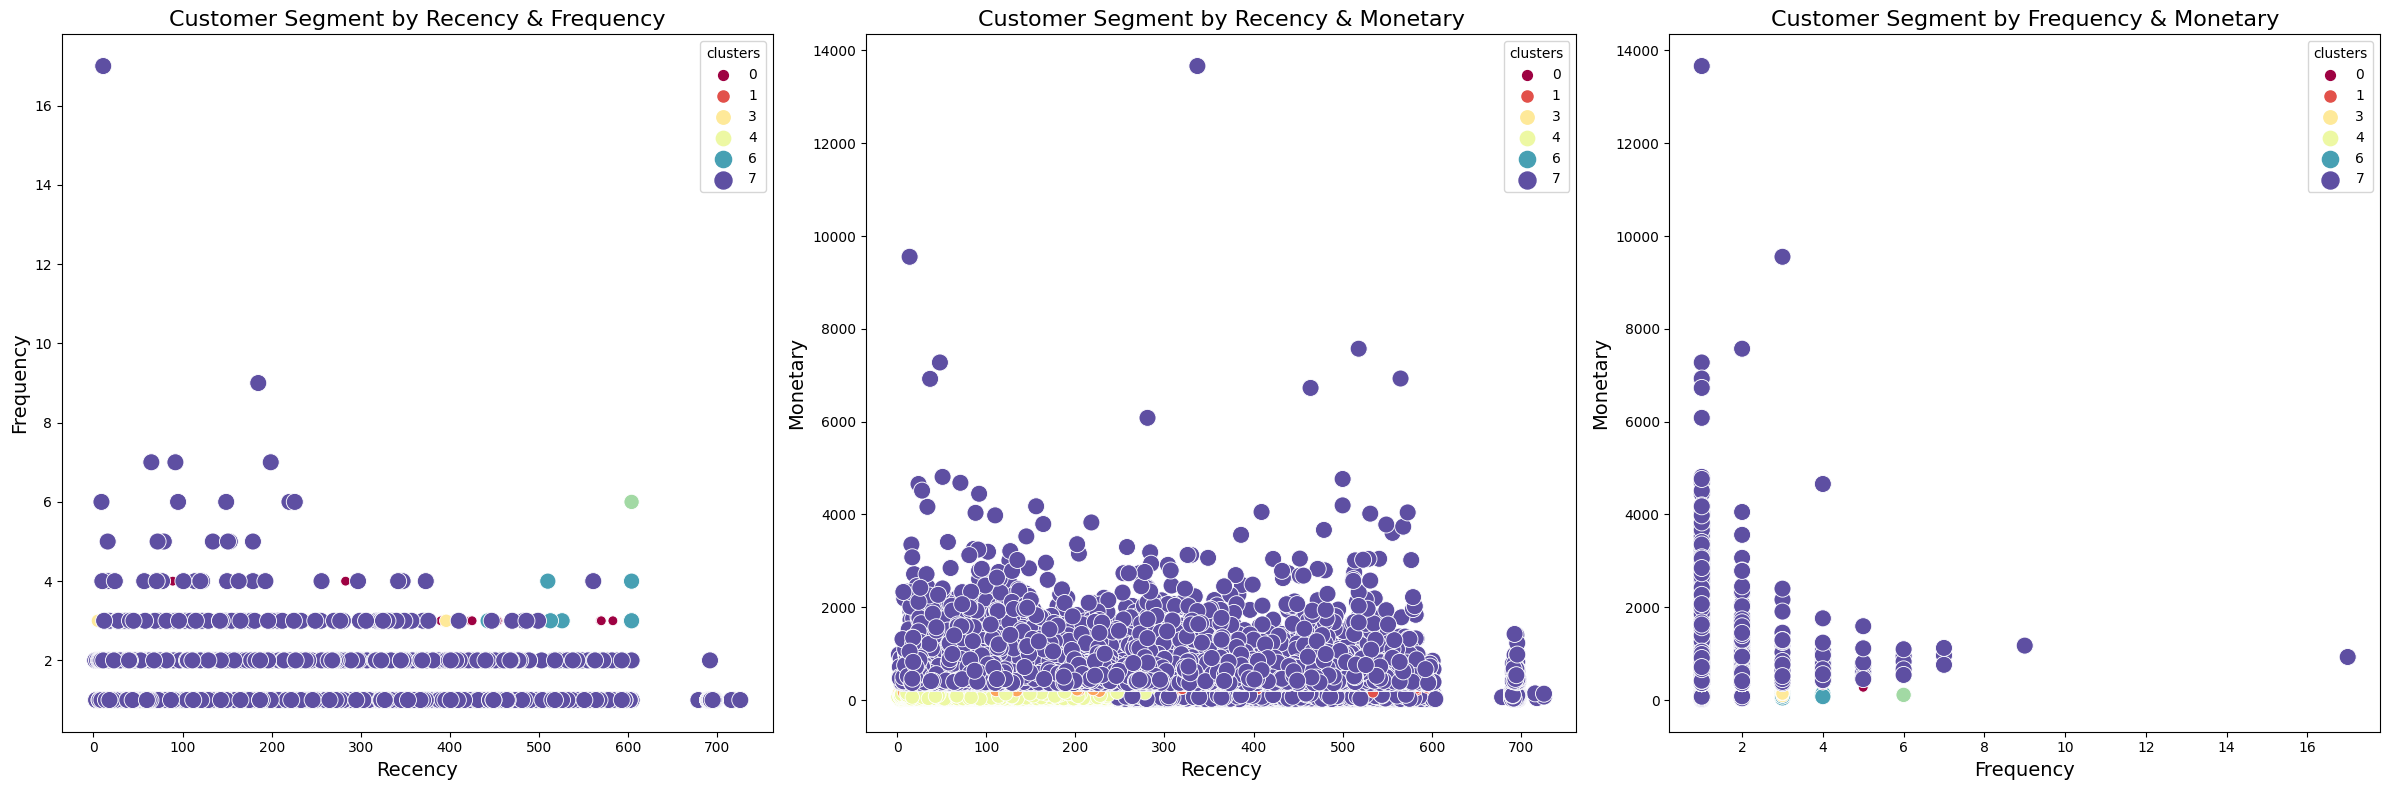

In [ ]:
rfm_monetary_outliers = rfm_data[rfm_data["monetary"] > monetary_upper_thres].copy()
rfm_monetary_outliers["clusters"] = [max(np.unique(model.labels_))] * len(rfm_monetary_outliers)

plot_rfm_segmentation(pd.concat([birch_segmentation, rfm_monetary_outliers], axis=0))

## RFM Segmentation

In [24]:
rfm_data.describe().T

,count,mean,std,min,25%,50%,75%,max
recency,96090.0,241.672089,153.400070,1.0,117.00,222.0,351.0000,726.00
frequency,96090.0,1.034665,0.213879,1.0,1.00,1.0,1.0000,17.00
monetary,96090.0,166.552049,231.324551,0.0,63.12,108.0,183.5175,13664.08


In [25]:
r_labels = range(5,0,-1)
r_quartiles = pd.qcut(rfm_data["recency"], 5, labels=r_labels)

m_labels = range(1,6)
m_quartiles = pd.qcut(rfm_data["monetary"], 5, labels=m_labels)

rfm_data["R"] = r_quartiles.values
rfm_data["M"] = m_quartiles.values

def segment_F(x):
    if x >= 12:
        return 5
    elif x >= 9:
        return 4
    elif x >= 6:
        return 3
    elif x >= 3:
        return 2
    else:
        return 1

rfm_data["F"] = rfm_data["frequency"].apply(segment_F)
rfm_data["RFM"] = rfm_data["R"].astype(str) + rfm_data["F"].astype(str) + rfm_data["M"].astype(str)

def RFM_segmentation(x):
    if x in [555, 554, 544, 545, 454, 455, 445] :
        return 'Champions'
    elif x in [543, 444, 435, 355, 354, 345, 344, 335] :
        return 'Loyal'
    elif x in [553, 551, 552, 541, 542, 533, 532, 531, 452, 451, 442, 441, 431, 453, 433, 432, 423, 353, 352, 351, 342, 341, 333, 323] :
        return 'Potential Loyalist'
    elif x in [512, 511, 422, 421, 412, 411, 311] :
        return 'New Customers'
    elif x in [525, 524, 523, 522, 521, 515, 514, 513, 425, 424, 413, 414, 415, 315, 314, 313] :
        return 'Promising'
    elif x in [535, 534, 443, 434, 343, 334, 325, 324] :
        return 'Need Attention'
    elif x in [331, 321, 312, 221, 213, 231, 241, 251] :
        return 'About To Sleep'
    elif x in [255, 254, 245, 244, 253, 252, 243, 242, 235, 234, 225, 224, 153, 152, 145, 143, 142, 135, 134, 133, 125, 124] :
        return 'At Risk'
    elif x in [155, 154, 144, 214,215,115, 114, 113] :
        return 'Cannot Lose Them'
    elif x in [332, 322, 233, 232, 223, 222, 132, 123, 122, 212, 211] :
        return 'Hibernating Customers'
    elif x in [111, 112, 121, 131, 141, 151] :
        return 'Lost Customers'

rfm_data['RFM_segment'] = rfm_data['RFM'].astype(int).apply(RFM_segmentation)
display(rfm_data["RFM_segment"].value_counts().reset_index())

#rfm_data.to_csv("../data/rfm_data2.csv", index=False)

,RFM_segment,count
0,Promising,35060
1,New Customers,18861
2,Cannot Lose Them,18654
3,Lost Customers,8018
4,Hibernating Customers,7849
5,About To Sleep,7539
6,At Risk,66
7,Need Attention,34
8,Loyal,5
9,Potential Loyalist,3


### Visualize Clusters

<Figure size 2400x800 with 0 Axes>

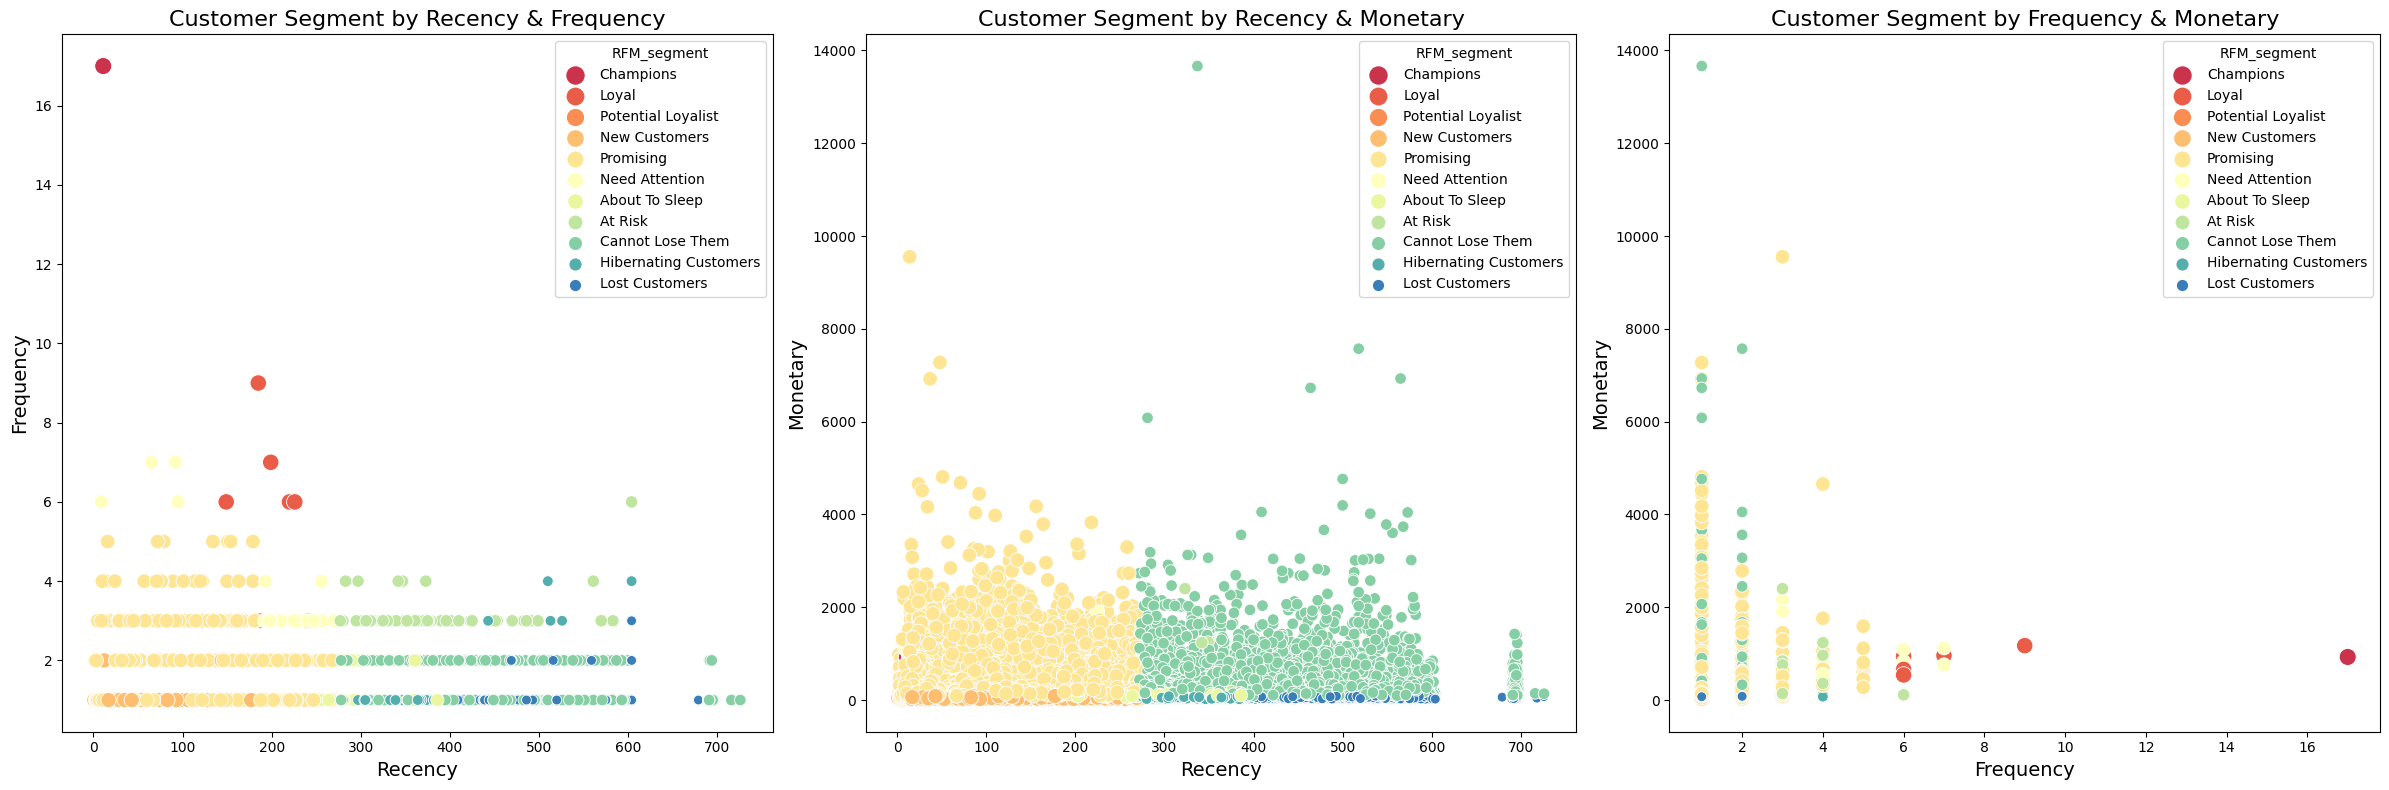

In [33]:
plt.figure(figsize=(24,8), facecolor='w')
segment = ['Champions', 'Loyal', 'Potential Loyalist', 'New Customers', 'Promising', 'Need Attention', 'About To Sleep', 'At Risk', 'Cannot Lose Them', 'Hibernating Customers', 'Lost Customers']

plot_rfm_segmentation(rfm_data, hue='RFM_segment', size='RFM_segment', size_order=segment, hue_order=segment)

In [ ]:
# def RFM_segmentation_score(x):
#     if x == 'Champions':
#         return 11
#     elif x == 'Loyal':
#         return 10
#     elif x == 'Potential Loyalist':
#         return 9
#     elif x == 'New Customers':
#         return 8
#     elif x == 'Promising':
#         return 7
#     elif x == 'Need Attention':
#         return 6
#     elif x == 'About To Sleep':
#         return 5
#     elif x == 'At Risk':
#         return 4
#     elif x == 'Cannot Lose Them':
#         return 3
#     elif x == 'Hibernating Customers':
#         return 2
#     elif x == 'Lost Customers':
#         return 1
    
# tmp = rfm_data[rfm_data["monetary"] <= thres].copy()
# tmp['RFM_segment_score'] = tmp['RFM_segment'].apply(RFM_segmentation_score)

# scaler = RobustScaler()
# tmp_scaled = scaler.fit_transform(tmp[['recency', 'frequency', 'monetary']])
# print(silhouette_score(tmp_scaled, tmp['RFM_segment_score']))
# print(davies_bouldin_score(tmp_scaled, tmp['RFM_segment_score']))